### google涂鸦比赛:涂鸦图片识别

正常建模的思路：
1. 数据读取
2. 数据探索
- 样本数据查看
- 明细字段分布
3. 数据清理与整理，包括
- 异常字段处理
- 建模数据整理（增强、shuffle、batch）
4. 构建模型，其中，第一次可以使用RESNET作为baseline
5. 评估
6. 采用新的处理，循环3、4、5步来进行优化（图片越大越好，彩色优于黑白，RNN等更多模型，优化评估指标，多模型stacking）

特别需要注意的是，实际的数据非常的大，需要注意读取、解析、运行的顺序组合。本程序运行的数据是简化后的数据，一是记录数少了，二是图片仅保存线段端点对应的数值，不再采用图片的格式

In [81]:
import os
import ast
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
import json

from glob import glob
import cv2
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

pd.options.display.max_rows = 5 #设置显示最大的行数
sns.set(style="darkgrid")
%matplotlib inline

import tensorflow as tf
print(tf.__version__)
print(tf.test.is_gpu_available())

2.0.0
False


## 1 简易版数据导入

In [53]:
file_dir="D:/老婆/tensorflow_camp_202005to07/5.2-Google涂鸦识别挑战项目(上)/sub_train_simplified/"
files_directory = os.listdir(file_dir)#返回文件夹下所有文件的名称

In [54]:
# for file_name in files_directory:
#     xx=pd.read_csv( file_dir + file_name)
#     print(xx)
#     break

In [55]:
# 因为数据量很小，因此可以直接导入数据中；但是如果是完整数据，并不能直接进行这个操作，需要分批读入--解析图片--存进数据集
train = pd.DataFrame()
for file_name in files_directory:
    train = train.append(pd.read_csv( file_dir + file_name, index_col='key_id', usecols=[1, 2, 3, 5]))
# Shuffle data
train = shuffle(train, random_state=123)

## 2 数据探索

In [56]:
print('Train number of rows: ', train.shape[0])
print('Train number of columns: ', train.shape[1])
print('Train set features: %s' % train.columns.values)
print('Train number of label categories: %s' % len(files_directory))

Train number of rows:  340000
Train number of columns:  3
Train set features: ['drawing' 'recognized' 'word']
Train number of label categories: 340


In [57]:
count_gp = train.groupby(['word']).size().reset_index(name='count').sort_values('count', ascending=False)
top_10 = count_gp[:10]
bottom_10 = count_gp[count_gp.shape[0]-10:count_gp.shape[0]]

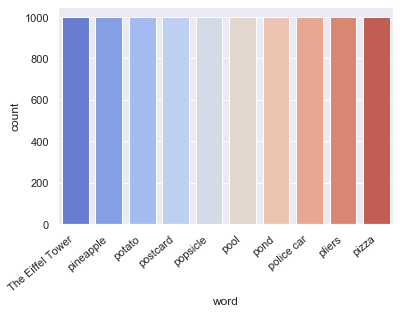

In [58]:
ax_t10 = sns.barplot(x="word", y="count", data=top_10, palette="coolwarm",ci=500)
ax_t10.set_xticklabels(ax_t10.get_xticklabels(), rotation=40, ha="right")
plt.show()

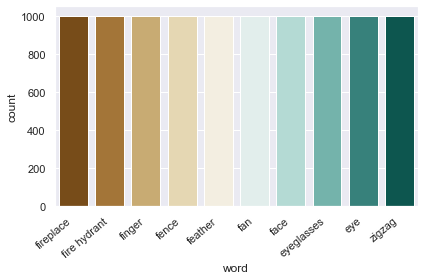

In [59]:
ax_b10 = sns.barplot(x="word", y="count", data=bottom_10, palette="BrBG", ci=500)
ax_b10.set_xticklabels(ax_b10.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

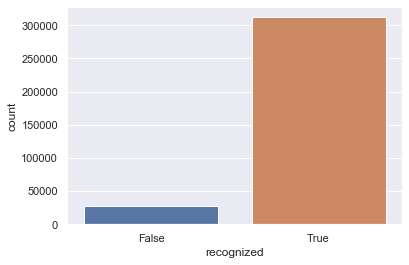

In [60]:
sns.countplot(x="recognized", data=train)
plt.show()

In [61]:
# 如果一个图一直没有被识别出来，那么我们认为有较大的可能该图质量不好，没有刻画出word对应的特征，也就是垃圾数据
# 如果垃圾数据的比例超过20%，那么就要删除,因为会影响训练
# 后期在评估模型结果的时候，也有影响；垃圾数据越多，评估准确度也会越低
train['recognized'].value_counts()

True     312073
False     27927
Name: recognized, dtype: int64

In [62]:
27927/(312073+27927)

0.08213823529411765

In [63]:
#分word来看一下这个垃圾数据的比例
rec_gp = train.groupby(['word', 'recognized']).size().reset_index(name='count')
rec_true = rec_gp[(rec_gp['recognized'] == True)].rename(index=str, columns={"recognized": "recognized_true", "count": "count_true"})
rec_false = rec_gp[(rec_gp['recognized'] == False)].rename(index=str, columns={"recognized": "recognized_false", "count": "count_false"})
rec_gp = rec_true.set_index('word').join(rec_false.set_index('word'), on='word')
rec_gp['count_false_rate']=rec_gp['count_false']/(rec_gp['count_false']+rec_gp['count_true'])
rec_gp=rec_gp.sort_values(by='count_false_rate',ascending=False)
rec_gp

,recognized_true,count_true,recognized_false,count_false,count_false_rate
word,,,,,
hot tub,True,806,False,194,0.194
stove,True,809,False,191,0.191
...,...,...,...,...,...
clock,True,988,False,12,0.012
rainbow,True,989,False,11,0.011


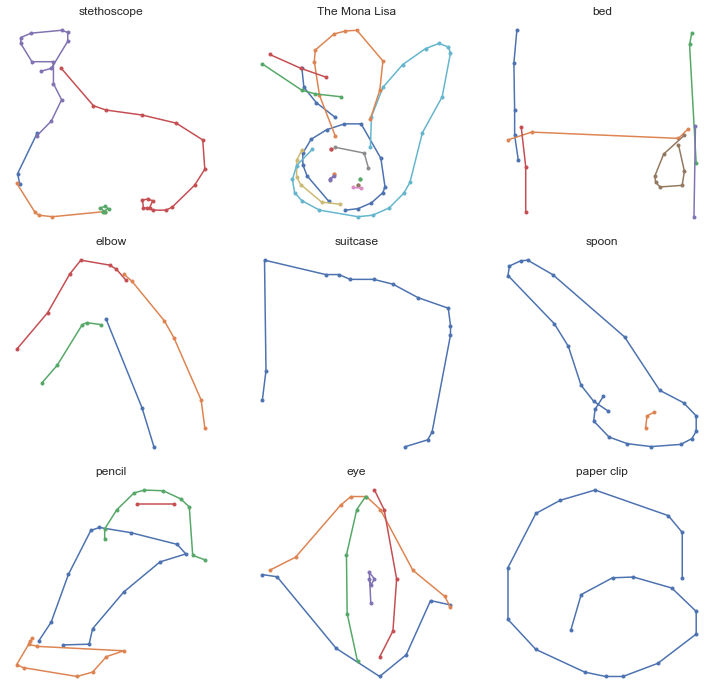

In [64]:
# 查看单个数据
words = train['word'].tolist()
drawings = [ast.literal_eval(pts) for pts in train[:9]['drawing'].values]#ast.leteral_eval将string转化为本来的格式
# for draw,raw in zip(drawings,train[:9]['drawing']):
#     print(draw)
#     print(raw)
#     break

plt.figure(figsize=(10, 10))
for i, drawing in enumerate(drawings):
    plt.subplot(330 + (i+1))
    for x,y in drawing:
        plt.plot(x, y, marker='.')
        plt.tight_layout()
        plt.title(words[i]);
        plt.axis('off')

## 3 数据清理与整理

1. 当前train['drawing']必须先转化为线段，然后线段转化为图片，然后图片在解析为矩阵，才能被卷积识别
2. 当前train['word']也需要从string编码成为数字

In [65]:
# 点坐标解析为线的图：使用cv2.line包
# @time_color True，那么每个线条的颜色与其他颜色不同
# @RGB True,那么是彩色的，color需要三维表示
# @lw 代表线条的粗细 thickness
def draw_cv2(raw_strokes, BASE_SIZE=256,size=256, lw=6, time_color=True,RGB=True):
    img = np.zeros((BASE_SIZE, BASE_SIZE), np.uint8)
    if RGB==True:
        for t, stroke in enumerate(raw_strokes):
            points_count = len(stroke[0]) - 1
            grad = 255//points_count
            for i in range(points_count):
                color = (255,255 - min(t, 10) * 13,max(255 - grad*i, 20)) if time_color else (255,255,255)
                _ = cv2.line(img, (stroke[0][i], stroke[1][i]),
                             (stroke[0][i + 1], stroke[1][i + 1]), color, lw)
    #             cv2.line(img, pt1, pt2, color[, thickness[, lineType[, shift]]])
    #             cv2.line Draws a line segment connecting two points
    else:
        for t, stroke in enumerate(raw_strokes):
            for i in range(len(stroke[0]) - 1):
                color = 255 - min(t, 10) * 13 if time_color else 255
                _ = cv2.line(img, (stroke[0][i], stroke[1][i]),
                             (stroke[0][i + 1], stroke[1][i + 1]), color, lw)

    if size != BASE_SIZE:
        return cv2.resize(img, (size, size)) 
    else:
        return img

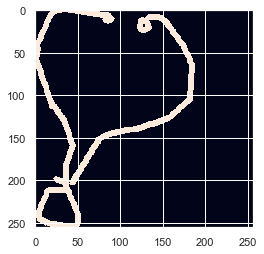

In [66]:
plt.imshow(draw_cv2(drawings[0]))

##### 接下来考虑用tfrecord,还是from_generator, 还是textlinedataset来读取
##### 练习使用tfrecord吧

In [67]:
tfrecord_file = "./google_train.tfrecords"

In [88]:
# 创建tfrecord
with tf.io.TFRecordWriter(tfrecord_file) as writer:
    for (i,filename) in enumerate(files_directory):#i用于生成label,每次csv对应着不同的分类
        df = pd.read_csv(file_dir+filename)
        df['drawing'] = df['drawing'].apply(json.loads)#Deserialize ``s`` to a Python object
        for row in range(df.shape[0]):
            drawing = df.loc[row,'drawing']
            img = draw_cv2(drawing,BASE_SIZE=128, size=128, lw=6)
            img = img.tostring()
            label = i
            # 建立 tf.train.Feature 字典
            feature = {                             
                    'image': tf.train.Feature(bytes_list=tf.train.BytesList(value=[img])),  # 图片是一个 Bytes 对象
                    'label': tf.train.Feature(int64_list=tf.train.Int64List(value=[label]))   # 标签是一个 Int 对象
                }
            example = tf.train.Example(features=tf.train.Features(feature=feature)) # 通过字典建立 Example
            writer.write(example.SerializeToString())   # 将Example序列化并写入 TFRecord 文件

In [86]:
# help(json.loads)

In [101]:
# 读取tfrecord

#注意多个不同的数据集，取了同一个名称。这主要是因为数据集可能很大，电脑硬件可能不支持。覆盖就可以节省空间

train_dataset = tf.data.TFRecordDataset(tfrecord_file)    
# 定义Feature结构
feature_description = { 
    'image': tf.io.FixedLenFeature([], tf.string),
    'label': tf.io.FixedLenFeature([], tf.int64),
}

# 将 TFRecord 文件中的每一个序列化的 tf.train.Example 解码
def _parse_example(example_string): 
    feature_dict = tf.io.parse_single_example(example_string, feature_description)
    image = tf.io.decode_raw(feature_dict['image'], tf.uint8)    # 解码JPEG图片
    image = tf.reshape(image, [128,128,1])
    image = tf.dtypes.cast(image,tf.float32)
    image = image / 255.0
    label = tf.one_hot(feature_dict['label'],depth=340)
    return image, label

train_dataset = train_dataset.map(_parse_example)

train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
# train_dataset = train_dataset.shuffle(buffer_size=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(buffer_size=100000)
train_dataset = train_dataset.batch(64)

In [105]:
# 注意此处没有验证集，可以在读取的时候，取出row为10倍数的作为验证集（也就是说，验证集取10%）

## 4 构建模型

In [107]:
class MobileNetModel(tf.keras.models.Model):
    def __init__(self, size, n_labels, **kwargs):
        super(MobileNetModel, self).__init__(**kwargs)
        self.base_model = tf.keras.applications.MobileNet(input_shape=(size, size, 1), include_top=False, weights=None, classes=n_labels)
        self.flatten = tf.keras.layers.Flatten()
        self.dense = tf.keras.layers.Dense(1024, activation='relu')
        self.outputs =  tf.keras.layers.Dense(n_labels, activation='softmax')

        
    def call(self, inputs):
        x = self.base_model(inputs)
        x = self.flatten(x)
        x = self.dense(x)
        output_ = self.outputs(x)
        return output_

In [108]:
model = MobileNetModel(size=128,n_labels=340)

loss_object = tf.keras.losses.CategoricalCrossentropy()


learning_rate = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)


train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.CategoricalAccuracy(name='train_accuracy')
train_top3_accuracy = tf.keras.metrics.TopKCategoricalAccuracy(k=3,name='train_top_3_categorical_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.CategoricalAccuracy(name='test_accuracy')
test_top3_accuracy = tf.keras.metrics.TopKCategoricalAccuracy(k=3,name='test_top_3_categorical_accuracy')


# @tf.function
def train_one_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images)
        loss = loss_object(labels, predictions)
     
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_accuracy(labels, predictions)
    train_top3_accuracy(labels, predictions)

def val_one_step(images, labels):
    predictions = model(images)
    t_loss = loss_object(labels, predictions)

    test_loss(t_loss)
    test_accuracy(labels, predictions)
    test_top3_accuracy(labels, predictions)

In [ ]:
EPOCHS=10
for epoch in range(EPOCHS):
    # 在下一个epoch开始时，重置评估指标
    train_loss.reset_states()
    train_accuracy.reset_states()
    train_top3_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()
    test_top3_accuracy.reset_states()

    for step,(images, labels) in enumerate(train_dataset):
        train_one_step(images, labels)
        
        if step % 200 == 0:
            print("step:{0}; Samples:{1}; Train Loss:{2}; Train Accuracy:{3},Train Top3 Accuracy:{4}".format(step, (step + 1) * 1024, 
                                                                                                             train_loss.result(), 
                                                                                                             train_accuracy.result()*100, 
                                                                                                             train_top3_accuracy.result()*100))




    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
    print(template.format(epoch + 1,
                          train_loss.result(),
                          train_accuracy.result() * 100,
                          train_top3_accuracy()*100,
                          test_loss.result(),
                          test_accuracy.result() * 100,
                          test_top3_accuracy()*100
                         ))

step:0; Samples:1024; Train Loss:5.828949451446533; Train Accuracy:3.125,Train Top3 Accuracy:100.0
